In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
#sant_file = "train_ver2.csv"
#outfile = "train_clean.csv"

sant_file = "test_ver2.csv"
outfile = "test_clean.csv"


In [39]:
df = pd.read_csv(sant_file)

/Users/bhaskar.dutta/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
idx_=1
for col_ in df.columns:
    print (idx_,col_)
    idx_+=1

(1, 'fecha_dato')
(2, 'ncodpers')
(3, 'ind_empleado')
(4, 'pais_residencia')
(5, 'sexo')
(6, 'age')
(7, 'fecha_alta')
(8, 'ind_nuevo')
(9, 'antiguedad')
(10, 'indrel')
(11, 'ult_fec_cli_1t')
(12, 'indrel_1mes')
(13, 'tiprel_1mes')
(14, 'indresi')
(15, 'indext')
(16, 'conyuemp')
(17, 'canal_entrada')
(18, 'indfall')
(19, 'tipodom')
(20, 'cod_prov')
(21, 'nomprov')
(22, 'ind_actividad_cliente')
(23, 'renta')
(24, 'segmento')


#### Get unique customers 

In [41]:
print( "total records :" ,df["ncodpers"].count())
print("Unique customers : " ,len(df["ncodpers"].unique()))

('total records :', 929615)
('Unique customers : ', 929615)


### Find all the rows that are null across the dataset

In [42]:
df.isnull().sum()

fecha_dato                    0
ncodpers                      0
ind_empleado                  0
pais_residencia               0
sexo                          5
age                           0
fecha_alta                    0
ind_nuevo                     0
antiguedad                    0
indrel                        0
ult_fec_cli_1t           927932
indrel_1mes                  23
tiprel_1mes                  23
indresi                       0
indext                        0
conyuemp                 929511
canal_entrada              2081
indfall                       0
tipodom                       0
cod_prov                   3996
nomprov                    3996
ind_actividad_cliente         0
renta                         0
segmento                   2248
dtype: int64

##### ult_fec_cli_it and conyuemp are almost all null, hence take them off from the dataset

In [43]:
df = df.drop(["ult_fec_cli_1t", "conyuemp"], axis=1) 

### Now lets fill in missing values, but first convert obviously numeric data

In [44]:
df["age"]   = pd.to_numeric(df["age"], errors="coerce") 
df["antiguedad"]   = pd.to_numeric(df["antiguedad"], errors="coerce") 
df["renta"] = pd.to_numeric(df["renta"],errors="coerce")

###### indrel_1mes has unique values 1,2,3,4 and nan. Following is from documentation
Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)
Hence assuming nan is 'P' and assign it value 5

In [45]:
df["indrel_1mes"].unique()

array([ 1.,  3., nan])

In [46]:
df["indrel_1mes"]   = pd.to_numeric(df["indrel_1mes"], errors="coerce") 

df.loc[df.indrel_1mes.isnull(),"indrel_1mes"] = 5.0

In [47]:
#verify
df["indrel_1mes"].unique()

array([1., 3., 5.])

In [48]:
df["indrel_1mes"].value_counts()

1.0    929565
3.0        27
5.0        23
Name: indrel_1mes, dtype: int64

###### Renta :  Backfill null values with a global mean. 
A better solution would to backfill with a per province and age conditioned

In [49]:
df.loc[df.renta.isnull() ,"renta"] = np.mean(df.loc[df.renta.notnull() ,"renta"].values)

In [50]:
# verify
df.loc[df.renta.isnull() ,"renta"].values

array([], dtype=float64)

#### Antiguedad : clean obvious senority issues
set values < 0 to be 0

In [51]:
df[df["antiguedad"] < 0] = 0

In [52]:
df["antiguedad"].value_counts()

8      26335
32     23415
9      22972
20     21108
11     20420
44     18531
21     17923
56     16238
23     15940
34     15559
19     15137
55     14530
43     13959
7      13932
46     13587
47     13434
45     13428
31     13225
33     12710
57     12156
35     11379
22      9970
10      9944
58      9489
54      9369
18      8625
59      7047
5       6762
175     6244
4       6124
       ...  
235      846
84       806
229      800
230      800
225      772
245      761
78       760
246      722
240      711
239      706
85       702
86       674
226      668
249      631
243      604
247      599
214      542
244      512
241      504
237      459
252      443
251      419
238      325
253      244
250      191
254      152
0        132
257      102
255       84
256       77
Name: antiguedad, Length: 258, dtype: int64

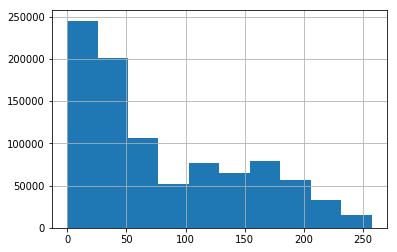

In [53]:
df['antiguedad'].hist(bins=10)

#### Age : age 
Mean customer age is 40 . Backfill nulls with mean
Truncate age > 100 as 100

In [54]:
df["age"].describe()

count    929615.000000
mean         40.249653
std          17.185244
min           0.000000
25%          25.000000
50%          39.000000
75%          51.000000
max         164.000000
Name: age, dtype: float64

In [55]:
df.loc[df.age.isnull() ,"age"] = 40

In [56]:
df[df["age"] > 100] = 100

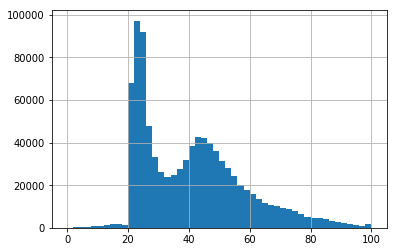

In [57]:
df['age'].hist(bins=50)

###### Pais_residencia :
Majority of data is from province ES. might help to remove values from others since data is highly imbalanced


In [58]:
df['pais_residencia'].describe() 

count     929615
unique       120
top           ES
freq      924626
Name: pais_residencia, dtype: object

##### Indresi : Residence index S if residence country is same as bank or N
Majority is S ..

In [59]:
df["indresi"].value_counts()

S      924627
N        3994
100       991
0           3
Name: indresi, dtype: int64

##### indext : Foreigner index S = Yes 
Majority is S ..

In [60]:
df["indext"].value_counts()

N      882558
S       46063
100       991
0           3
Name: indext, dtype: int64

In [61]:
df["indfall"].value_counts()

N      926368
S        2253
100       991
0           3
Name: indfall, dtype: int64

In [62]:
df["segmento"].value_counts()

02 - PARTICULARES     544439
03 - UNIVERSITARIO    346028
01 - TOP               35949
100                      991
0                          3
Name: segmento, dtype: int64

In [63]:
df["ind_empleado"].value_counts()

N      928102
100       991
B         218
F         152
A         148
0           3
S           1
Name: ind_empleado, dtype: int64

In [64]:
df["sexo"].value_counts()

V      504137
H      424479
100       991
0           3
Name: sexo, dtype: int64

###### Seems like same number of rows have 100 and 0 vals hences removing them

In [65]:
df_d_ = df.loc[df["sexo"] ==100]
df = df.drop(df_d_.index.values)

In [66]:
df_d_ = df.loc[df["sexo"] == 0]
df = df.drop(df_d_.index.values)

In [67]:
# single value : hence remove
df["tipodom"].value_counts()

1    928621
Name: tipodom, dtype: int64

In [68]:
df = df.drop(["tipodom"], axis=1) 

In [69]:
df = df.drop(df.loc[df["pais_residencia"].isna(),"pais_residencia"].index.values)

df["pais_residencia"].value_counts()


ES    924626
FR       311
AR       287
GB       286
DE       281
US       231
CO       211
IT       179
RO       175
MX       156
BR       141
VE       136
EC       130
CH       124
BO        93
BE        93
PT        90
PY        87
CL        59
PE        54
NL        47
RU        45
CU        44
PL        38
SE        37
CN        33
UY        30
AT        29
UA        29
BG        28
       ...  
MZ         2
JM         2
CG         2
ET         2
GW         2
OM         2
LV         1
LY         1
MT         1
ML         1
MM         1
KZ         1
SL         1
TN         1
KH         1
IS         1
GH         1
GI         1
GM         1
GE         1
DJ         1
CD         1
CF         1
BZ         1
BM         1
KW         1
AL         1
ZW         1
TG         1
LB         1
Name: pais_residencia, Length: 118, dtype: int64

In [70]:
df.to_csv(outfile,index=False)

In [36]:
df["sexo"].unique()

array(['H', 'V', nan], dtype=object)